In [ ]:
### First we have downloaded a net CDF from the Copernicus Data Store: https://cds.climate.copernicus.eu

### Required Changes:

- The complete table should be saved in the directory: `data/generated/index_table_output`
    - The file name must include the start and end dates for easier identification.

- For the functions `generate_etccdi_temporal_tables` and `generate_etccdi_temporal_tables__centroid`:
    - Suppress the printing of each graphic iteration during execution to reduce unnecessary output.

- Ensure that all generated graphics reference a single, consistent scale (legend).

- Issue with validation if:
    - partial years are set in the parameters option 
    - ex. monthly data is allowed but parameters request only part of given year.


# To-Do List

## dependencies file
- This is started as requirements.tx
    - Go through each function (.py) and pull out all dependencies 
    - compile into one simplified list
    - consult viewser and check which are absent
    - make list of just the absent to install before running

## Decision Tree Development
- Create a **decision tree for defensible methods** based on different applications:
    - If performing at an admin or country scale, use method X.
    - Address the question: "At what scale does the utility of finer-grained PRIOgrid data diminish?" 
    - Incorporate considerations of 'other' shapefile extents.

## API Considerations
- Investigate potential **API changes**:
    1. Ensure the `define_request.py` script is correctly referenced.
    2. Contact CDS to determine their API update schedule (e.g., every 6 months or yearly).
    3. Check the **CDS API forum** for transparency on updates.

## Feature Enhancements
- Add **descriptive statistics**:
    - Include basic summary stats for the requested indices.
- Allow users to view country-specific data:
    - Avoid packaging into larger datasets.
  
## Additional Notes
- Add a **section in the documentation** clarifying how to migrate workflows toward ingestion smoothly.


In [1]:
import pandas as pd
import xarray as xr
import numpy as np

In [2]:
from ingester3.extensions import *

In [3]:
from setup_environment import setup_utils_path
setup_utils_path()

Utils path added to Python Path: /Users/gbenz/Documents/Climate_Data/climate_extremes/utils


In [4]:

# Format API Request ----------------------------------------------------------------
from unzip import unzip_etccdi_package
from correct_longitude import transform_longitudinal_values
from temporal_index import find_etccdi_timeindex, translate_index_to_daterange
from define_request import generate_and_validate_request

# Provide Metadata ------------------------------------------------------------------
from give_metadata import give_metadata

# Build API Request -----------------------------------------------------------------
from cds_api_pull import pull_from_cds_api

# Methods ---------------------------------------------------------------------------
from etccdi_to_pg__pointquery import generate_etccdi_temporal_tables__centroid
from etccdi_to_pg import generate_etccdi_temporal_tables

# Validation ------------------------------------------------------------------------
from give_reference_frame import provide_reference_frame
from id_null_values import report_null_etccdi_values

## Access with Copernicus Data Store API:

### You must have both a Copernicus Data Store account and have followed the proceeding instructions on setting up the CDSAPI before you can retrieve and process data from this toolbox. 

#### The following instructions reference the CDSAPI set up guide: https://cds.climate.copernicus.eu/how-to-api


The final objective is to construct a main.py function that accepts the parameters below and automatically computes the process!

## API Request and Processing Parameters

### API Request Parameters
These parameters define the data retrieved via the API request:
- **`variable`**: Specifies the data variable of interest.
- **`product_type`**: Indicates the base product type.
- **`experiment`**: Defines the experimental setup or scenario.
- **`temporal_aggregation`**: Determines the temporal resolution of the data.

### Processing Parameters
These parameters guide the processing workflow:
- **`start_year`**: `'1995'`
- **`start_month`**: `'01'`
- **`end_year`**: `'2000'`
- **`end_month`**: `'12'`

### Method Selection
Choose a resampling or data alignment method:
- **Bilinear sampling**: Applies weighted interpolation for smoother results.
- **Point neighbor**: Maps the closest neighboring value preserving the original coarse resolution.

### (In Development) Extent Selection
Additional options for spatial analysis:
- Empirical distributions based on basin-specific extents.
- Future iterations will enable a 'hotspot' methodology for comparison with global metrics.


## Example of CDS Request

```
import cdsapi

dataset = "sis-extreme-indices-cmip6"
request = {
    "variable": ["cold_days"], 
    "product_type": ["base_period_1961_1990"],
    "model": ["hadgem3_gc31_ll"],
    "ensemble_member": ["r1i1p1f3"],
    "experiment": ["ssp1_2_6"],
    "temporal_aggregation": ["monthly"],
    "period": ["201501_210012"],
    "version": ["2_0"]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()
```   
``` 
dataset = "sis-extreme-indices-cmip6"
request = {
    "variable": ["consecutive_dry_days"],
    "product_type": ["base_independent"],
    "model": ["hadgem3_gc31_ll"],
    "ensemble_member": ["r1i1p1f3"],
    "experiment": ["ssp1_2_6"],
    "temporal_aggregation": ["yearly"],
    "period": ["2015_2100"],
    "version": ["2_0"]
}
```


## Informing parameters

This series of prompts will help constrain appropriate parameters to construct a request that matches the CDS API

First, select a temporal aggregation (yearly / monthly)

- if yearly:
supply a response that reads: (all variables are available at yearly temporal resolution. Here a list of all available climate indices.)

- if monthly:
supply a response that reads: (Select indices are available at a monthly temporal resolution. Select from the following:)


supply the climate index from the list of available variables. Please provide the name exactly as it is written in the list.

- add code check (Is the variable located within the list?) 
    - if not, supply prompt to check spelling

Next, select the climate 'experiment' used to process the derived climate indices. You may select from 'historical, ssp2.. sspx... and sspz

- if historical AND monthly
    - align appropriate 'period' variable
    - etcd (applied to sspx_x and so on)



In [ ]:
import pandas as pd

# Data for the DataFrame
data = {
    "product_type": [
        "base_independent", "base_independent", "base_independent", "base_independent",
        "base_independent", "base_independent", "base_independent", "base_independent",
        "base_independent", "base_independent", "base_independent", "base_independent",
        "base_independent", "base_independent", "base_independent", "base_independent",
        "base_independent", "base_independent", "base_independent", "base_period_1961_1990",
        "base_period_1961_1990", "base_period_1961_1990", "base_period_1961_1990"
    ],
    "variable": [
        "consecutive_dry_days", "consecutive_wet_days", "diurnal_temperature_range", "frost_days",
        "growing_season_length", "heavy_precipitation_days", "ice_days", "maximum_1_day_precipitation",
        "maximum_5_day_precipitation", "maximum_value_of_daily_maximum_temperature",
        "minimum_value_of_daily_maximum_temperature", "maximum_value_of_daily_minimum_temperature",
        "minimum_value_of_daily_minimum_temperature", "number_of_wet_days", "simple_daily_intensity_index",
        "summer_days", "total_wet_day_precipitation", "tropical_nights", "very_heavy_precipitation_days",
        "cold_days", "cold_nights", "warm_days", "warm_nights"
    ],
    "temporal_aggregation": [
        "annual", "annual", "monthly or annual", "annual", "annual", "annual", "annual", "monthly or annual",
        "monthly or annual", "monthly or annual", "monthly or annual", "monthly or annual", "monthly or annual",
        "annual", "annual", "annual", "annual", "annual", "annual", "monthly or annual", "monthly or annual",
        "monthly or annual", "monthly or annual"
    ]
}

# Create the DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

#first, 


### Product Type and Variable Temporal Aggregation

| product_type            | variable                           | temporal_aggregation |
|-------------------------|------------------------------------|----------------------|
| base_independent         | consecutive_dry_days               | annual               |
| base_independent         | consecutive_wet_days               | annual               |
| base_independent         | diurnal_temperature_range          | monthly or annual    |
| base_independent         | frost_days                         | annual               |
| base_independent         | growing_season_length              | annual               |
| base_independent         | heavy_precipitation_days           | annual               |
| base_independent         | ice_days                           | annual               |
| base_independent         | maximum_1_day_precipitation        | monthly or annual    |
| base_independent         | maximum_5_day_precipitation        | monthly or annual    |
| base_independent         | maximum_value_of_daily_maximum_temperature | monthly or annual    |
| base_independent         | minimum_value_of_daily_maximum_temperature | monthly or annual    |
| base_independent         | maximum_value_of_daily_minimum_temperature | monthly or annual    |
| base_independent         | minimum_value_of_daily_minimum_temperature | monthly or annual    |
| base_independent         | number_of_wet_days                 | annual               |
| base_independent         | simple_daily_intensity_index       | annual               |
| base_independent         | summer_days                        | annual               |
| base_independent         | total_wet_day_precipitation        | annual               |
| base_independent         | tropical_nights                    | annual               |
| base_independent         | very_heavy_precipitation_days      | annual               |
| base_period_1961_1990    | cold_days                          | monthly or annual    |
| base_period_1961_1990    | cold_nights                        | monthly or annual    |
| base_period_1961_1990    | warm_days                          | monthly or annual    |
| base_period_1961_1990    | warm_nights                        | monthly or annual    |

The table above defines the `product_type`, `variable`, and the corresponding `temporal_aggregation` classification options for required parameters. Variables that are only available on a yearly basis are labeled as "annual," while others that can be reported on both monthly and annual bases are labeled as "monthly or annual."

### Experiment Period Mapping

| experiment  | period        |
|-------------|---------------|
| historical | 185001_201412 |
| ssp1_2_6   | 201501_210012 |
| ssp2_4_5   | 201501_210012 |
| ssp5_8_5   | 201501_210012 |


In [ ]:
# Read configuration from the .txt file
import os
base_dir= os.getcwd()
config_file_path = f'{base_dir}/request.txt'  # Adjust this path to where your .txt file is located

config = {}
with open(config_file_path, 'r') as file:
    for line in file:
        key, value = line.strip().split(':')
        config[key.strip()] = value.strip()

# Assign variables from the config dictionary
p_variable = config.get('p_variable')
p_product_type = config.get('p_product_type')
p_experiment = config.get('p_experiment')
p_temporal_aggregation = config.get('p_temporal_aggregation')

In [ ]:
print(p_variable)

In [15]:
p_variable = "consecutive_dry_days"
p_product_type="base_independent"
p_experiment="historical"
p_temporal_aggregation="yearly"

#-----------------------------------------------------------
# Define Start Year & Month
#-----------------------------------------------------------
start_year = '1990'
start_month = '01'
#-----------------------------------------------------------
# Define End Year & Month
end_year = '1993'
end_month = '02'
#-----------------------------------------------------------
method = 'raster_query' # or raster_query
#-----------------------------------------------------------
save_tif = 'yes' # or no
#-----------------------------------------------------------

#country_selection = None

In [16]:
# Now, calling the function will generate and validate the request

request = generate_and_validate_request(
    variable=p_variable,
    product_type=p_product_type,
    experiment=p_experiment,
    temporal_aggregation=p_temporal_aggregation
)
temporal_aggregation_value = request['temporal_aggregation'][0]
print(temporal_aggregation_value)
display(request)

#-------------------------------------------------------------------
# Load a clean PG dataframe at a consistent temporal resolution
# to the request built
#-------------------------------------------------------------------

#reference_df = provide_reference_frame(request)

Request is valid.
yearly


{'variable': ['consecutive_dry_days'],
 'product_type': ['base_independent'],
 'model': ['hadgem3_gc31_ll'],
 'ensemble_member': ['r1i1p1f3'],
 'experiment': ['historical'],
 'temporal_aggregation': ['yearly'],
 'period': ['1850_2014'],
 'version': ['2_0'],
 'data_format': 'netcdf'}

The zip_file_name will appear in folder:

```
CLIMATE_EXTREMES/
├── data/
│   ├── raw_external/
│   │   └── cds_zip/
```

In [17]:
zip_file_name = pull_from_cds_api(request)

2024-12-04 16:25:50,328 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-12-04 16:25:50,328 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-12-04 16:25:50,328 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-12-04 16:25:50,329 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using t

9d63597c4074b0f4eefb5ed6ae388ebd.zip:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

The netcdf file will appear in folder: 

```
CLIMATE_EXTREMES/
├── data/
│   ├── generated/
│   │   └── netcd/

```

In [18]:
netcdf_file, etccdi_index = unzip_etccdi_package(zip_file_name)

cddETCCDI
Extracted file names: cddETCCDI_yr_HadGEM3-GC31-LL_historical_r1i1p1f3_no-base_v20190624_1850-2014_v2-0.nc


The adjusted netcdf file replaced the original file in location:

```
CLIMATE_EXTREMES/
├── data/
│   ├── generated/
│   │   └── netcd/
```

In [19]:
etccdi = transform_longitudinal_values(etccdi_index, netcdf_file)

The variable 'cddETCCDI' was found in the file path and the world continues to spin.
Original Latitude range: -89.375 to 89.375
Original Longitude range: 0.9375 to 359.0625
Adjusted Longitude range: -179.0625 to 179.0625


/Users/gbenz/miniforge3/envs/viewser/lib/python3.11/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/Users/gbenz/miniforge3/envs/viewser/lib/python3.11/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


Adjusted dataset saved to: /Users/gbenz/Documents/Climate_Data/climate_extremes/data/generated/netcdf/adjusted_cddETCCDI_yr_HadGEM3-GC31-LL_historical_r1i1p1f3_no-base_v20190624_1850-2014_v2-0.nc.nc


In [20]:
give_metadata(etccdi)

Latitude range: -89.375 to 89.375
Longitude range: -179.0625 to 179.0625
Latitude resolution: 1.25
Longitude resolution: 1.875
Global Metadata:
CDI: Climate Data Interface version 1.8.0 (http://mpimet.mpg.de/cdi)
history: Tue Nov 24 08:58:40 2020: cdo mergetime tasmax_day_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_18500101-19491230.nc tasmax_day_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19500101-20141230.nc ./merged/tasmax_day_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_18500101-20141230.nc
2019-06-19T11:16:23Z ; CMOR rewrote data to be consistent with CMIP6, CF-1.7 CMIP-6.2 and CF standards.;
2019-06-19T11:07:16Z MIP Convert v1.1.0, Python v2.7.12, Iris v1.13.0, Numpy v1.13.3, netcdftime v1.4.1.
source: HadGEM3-GC31-LL (2016): 
aerosol: UKCA-GLOMAP-mode
atmos: MetUM-HadGEM3-GA7.1 (N96; 192 x 144 longitude/latitude; 85 levels; top level 85 km)
atmosChem: none
land: JULES-HadGEM3-GL7.1
landIce: none
ocean: NEMO-HadGEM3-GO6.0 (eORCA1 tripolar primarily 1 deg with meridional refinement down to 1/3 de

In [11]:
reference_df = provide_reference_frame('yearly')


Generating empty PG scaffolders which will be used to validate the spatial and temporal completeness of the selected indice.
This is expected to take several minutes...



In [21]:
index_list, reference_filtered_time, report_temporal_dimensions = translate_index_to_daterange(etccdi, reference_df, temporal_aggregation_value, start_year, start_month, end_year, end_month)

No data found for 01 of the year 1990 but located data for the first available month.
Validation: Found data for Year: 1990, Month: 06 at index 140.

No data found for 02 of the year 1993 but located data for the first available month.
Validation: Found data for Year: 1993, Month: 06 at index 143.

The start index is: 140, and references 06 (month) of 1990 (year)

The end index is: 143, and references 06 (month) of 1993 (year)



### Params:

- time_index_list,
- netcdf, climate_index, 
- shapefile_path



Raster files:
```
CLIMATE_EXTREMES/
├── data/
│   ├── generated/
│   │   └── index_raster_output/
```

Final output table:
```
CLIMATE_EXTREMES/
├── data/
│   ├── generated/
│   │   └── index_table_output/
```


### Changes:

#### Do not print each iteration of the graphics!
- Complete for raster_query
- Finish for resample!

In [22]:
if method == 'raster_query':
    translated_filename = generate_etccdi_temporal_tables__centroid(index_list, etccdi, etccdi_index, report_temporal_dimensions, save_tif)

elif method == 'resample':
    translated_filename = generate_etccdi_temporal_tables(index_list, etccdi, etccdi_index, report_temporal_dimensions, save_tif)

else: 
    print('you have entered a bad prompt for the method parameter. Please restart.... ')

Processing time index: 140
Year: 1990 Month: 06
CRS is not set. Setting CRS to EPSG:4326


/Users/gbenz/miniforge3/envs/viewser/lib/python3.11/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/Users/gbenz/miniforge3/envs/viewser/lib/python3.11/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")
/Users/gbenz/Documents/Climate_Data/climate_extremes/utils/etccdi_to_pg__pointquery.py:118: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.geometry.centroid


Processing time index: 141
Year: 1991 Month: 06
CRS is not set. Setting CRS to EPSG:4326


/Users/gbenz/Documents/Climate_Data/climate_extremes/utils/etccdi_to_pg__pointquery.py:118: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.geometry.centroid


Processing time index: 142
Year: 1992 Month: 06
CRS is not set. Setting CRS to EPSG:4326


/Users/gbenz/Documents/Climate_Data/climate_extremes/utils/etccdi_to_pg__pointquery.py:118: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.geometry.centroid


Processing time index: 143
Year: 1993 Month: 06
CRS is not set. Setting CRS to EPSG:4326


/Users/gbenz/Documents/Climate_Data/climate_extremes/utils/etccdi_to_pg__pointquery.py:118: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.geometry.centroid


Final DataFrame saved to: /Users/gbenz/Documents/Climate_Data/climate_extremes/data/generated/index_table_output/cddETCCDI_yearly_199006_199306__centroid_process.csv
cddETCCDI_yearly_199006_199306__centroid_process.csv
All graphics saved to /Users/gbenz/Documents/Climate_Data/climate_extremes/docs/Graphics/Standard_review/cddETCCDI_layout.pdf


``translated_filename`` retrieves the summary table saved to:


``reference_filtered_time`` retrieves the primary reference table saved to:

## There was an error in report_null_etccdi_values:
proceeding code line concentrates on this

In [ ]:
index = str(translated_filename).split('_')[0]
print(index)

In [23]:
report_null_etccdi_values(translated_filename, reference_filtered_time, temporal_aggregation_value)

Total number of null values in 'validate_etccdi' DataFrame: 1654
   year  month  NaN_count
0  1990      6        247
1  1991      6        539
2  1992      6        265
3  1993      6        603


## Now you can migrate to the ingestion script

We want to intentionally keep these things seperate (lock / key) so unwanted things are not automatically ingested

- **Clarify migration to the ingestion script**:

In [ ]:
print( "Now you are ready to run the ingestion code located in .... ")

In [24]:

from pathlib import Path

def report_summary_stats(translated_filename):

    translated_filename

    project_root = Path.cwd()  # Set this to your project root manually if needed
    out_path = project_root / 'data' / 'generated' / 'index_table_output'
    extent_filename = out_path / translated_filename

    df = pd.read_csv(extent_filename)

    clim_value = translated_filename.split('_')[0]

    df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))  # Create a date column (set to first day of month)
    df_annual = df.groupby('year')[clim_value].agg(
    mean='mean', 
    percentile_25=lambda x: x.quantile(0.25),  # 25th percentile
    percentile_90=lambda x: x.quantile(0.90)   # 90th percentile
    ).reset_index()

    # extreme highs -----------------------------------------------------------------------------
    # ----- MEAN -----
    top_3_annual_mean = df_annual.nlargest(5, 'mean')
    #top_3_annual_mean_years = top_3_annual_mean['year'].tolist()

    #give list of the desired attribute:
    # mean
    top_3_annual_mean_values = top_3_annual_mean['mean'].values  # Get the first 3 mean values or less
    # year
    top_3_annual_mean_years_list = top_3_annual_mean['year'].values

    # ----- 90th percentile -----

    top_3_max = df_annual.nlargest(5, 'percentile_90')
    #top_3_max_years = top_3_max['year'].tolist()

    #give list of the desired attribute:
    # 90th percentile
    top_3_max_values = top_3_max['mean'].values  # Get the first 3 mean values or less
    # year
    top_3_max_years_list = top_3_max['year'].values

    # ----- 25th percentile -----

    top_3_min = df_annual.nlargest(5, 'percentile_25')
    #top_3_min_years = top_3_min['year'].tolist()

    #give list of the desired attribute:
    # 25th percentile
    top_3_min_values = top_3_min['mean'].values  # Get the first 3 mean values or less
    # year
    top_3_min_years_list = top_3_min['year'].values

    # --------------------------
    # define how many index values should appear: -- This applies to both df1 and df2 (same length and the variable referenced does not matter, also same length)
    index_count = len(top_3_min_years_list)
    index_val = list(range(1, index_count + 1))  # Generate the index dynamically
    # --------------------------

    # --------------------------
    # Generate Extreme High Summary DF (1)
    # --------------------------

    df1 = pd.DataFrame({
        'year (25th)': top_3_min_years_list.tolist(),
        '25th': top_3_min_values.tolist(),
        'year (90th)': top_3_max_years_list.tolist(),
        '90th': top_3_max_values.tolist(),
        'year (mean)': top_3_annual_mean_years_list.tolist(),
        'mean': top_3_annual_mean_values.tolist()
    }, index=index_val)

    # -------------------------------------------------------------------------------------------
    # extreme lows -----------------------------------------------------------------------------

    # ----- MEAN -----

    bottom_3_annual_mean = df_annual.nsmallest(5, 'mean')
    #bottom_3_annual_mean_years = bottom_3_annual_mean['year'].tolist()

    #give list of the desired attribute:
    # mean
    bottom_3_annual_mean_values = bottom_3_annual_mean['mean'].values  # Get the first 3 mean values or less
    # year
    bottom_3_annual_mean_years_list = bottom_3_annual_mean['year'].values

    # ----- 90th percentile -----

    bottom_3_max = df_annual.nsmallest(5, 'percentile_90')
    bottom_3_max_years = bottom_3_max['year'].tolist()

    #give list of the desired attribute:
    # 90th percentile
    bottom_3_max_values = bottom_3_max['mean'].values  # Get the first 3 mean values or less
    # year
    bottom_3_max_years_list = bottom_3_max['year'].values

    # ----- 25th percentile -----

    bottom_3_min = df_annual.nsmallest(5, 'percentile_25')
    bottom_3_min_years = bottom_3_min['year'].tolist()

    #give list of the desired attribute:
    # 25th percentile
    bottom_3_min_values = bottom_3_min['mean'].values  # Get the first 3 mean values or less
    # year
    bottom_3_min_years_list = bottom_3_min['year'].values

    # --------------------------
    # Generate Extreme High Summary DF (1)
    # --------------------------

    df2 = pd.DataFrame({
        'year (25th)': bottom_3_min_years_list.tolist(),
        '25th': bottom_3_min_values.tolist(),
        'year (90th)': bottom_3_max_years_list.tolist(),
        '90th': bottom_3_max_values.tolist(),
        'year (mean)': bottom_3_annual_mean_years_list.tolist(),
        'mean': bottom_3_annual_mean_values.tolist()
    }, index=index_val)

    return(df_annual, df1, df2)

In [25]:
df_an, df1, df2= report_summary_stats(translated_filename)

In [26]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os

def plot_statistics(variable, df_annual, df1, df2):

    project_root = Path.cwd()  # Set this to your project root manually if needed
    output_folder = project_root / 'docs' / 'Graphics' / 'Standard_review'

    file_name = os.path.join(output_folder, f'{variable}_Summary_plots.pdf')

    print_title = f'Annual Data Report of Climate Extreme Variable: {variable} '

    # Sample data for the tables (5 rows, 3 columns)
    # Convert the first column to integers (no decimals)
    df1[df1.columns[0]] = df1[df1.columns[0]].astype(int)

    # Round all other columns to 2 decimal places
    df1.iloc[:, 1:] = df1.iloc[:, 1:].round(2)

    # Convert the first column to integers (no decimals)
    df2[df2.columns[0]] = df2[df2.columns[0]].astype(int)

    # Round all other columns to 2 decimal places
    df2.iloc[:, 1:] = df2.iloc[:, 1:].round(2)


    # Create a figure
    fig = plt.figure(figsize=(15, 10))  # Adjust the figure size to fit 5 columns and 3 rows

    # Create a GridSpec with 3 rows and 5 columns (equal sizes for all subplots)
    gs = GridSpec(3, 5)  # 3 rows, 5 columns

    # Create subplots in the grid
    ax2 = fig.add_subplot(gs[0, 1:4])  # Top-center-left subplot

    ax6 = fig.add_subplot(gs[1, 0:2])  # Middle-left subplot
    ax8 = fig.add_subplot(gs[1:, 2:])  # Middle-center-right subplot

    ax11 = fig.add_subplot(gs[2, 0:2]) # Bottom-left subplot


    # Set titles for each subplot
    ax2.axis('off')
    ax2.text(0.5, 0.5, print_title, ha='center', va='center', fontsize=26, color='black', weight='bold')

    ax6.set_title("Report of maximum values",fontsize=16)  # Adjust the pad to control the distance between title and table
    table6 = ax6.table(cellText=df1.values, colLabels=df1.columns, loc='center', cellLoc='center', colLoc='center')
    ax6.axis('tight')
    ax6.axis('off')
    # Get the actual size of ax6 in inches (not normalized)
    bbox = ax6.get_window_extent().transformed(fig.dpi_scale_trans.inverted())  # Get axis bounding box in inches
    ax_width, ax_height = bbox.width, bbox.height  # Get the width and height of the axes in inches

    # Number of rows and columns
    num_columns = len(df1.columns)
    num_rows = len(df1)

    # Calculate the column width and row height to fit the axes' size
    column_width = ax_width / num_columns  # Divide the axis width by the number of columns
    column_width = 1.6  # Divide the axis width by the number of columns

    row_height = 1.6  # Divide the axis height by the number of rows, adding some space for margins

    # Apply the scaling to the table
    table6.scale(column_width, row_height)  # Scale both width and height proportionally


    # Adjust layout to make sure everything fits well
    plt.tight_layout()

    ax8.plot(df_annual['year'], df_annual['mean'], marker='o', color='b', label='Annual Mean')
    ax8.set_title(f'Annual average of {variable} over time')
    ax8.set_xlabel('Year')
    ax8.set_ylabel(f'{variable} Mean')
    ax8.legend()
    ax8.grid(True)


    ax11.set_title("Report of minimum values",fontsize=16)
    # Add table in ax6
    table11 = ax11.table(cellText=df2.values, colLabels=df1.columns, loc='center', cellLoc='center', colLoc='center')
    ax11.axis('tight')
    ax11.axis('off')
    # Get the actual size of ax6 in inches (not normalized)
    bbox = ax11.get_window_extent().transformed(fig.dpi_scale_trans.inverted())  # Get axis bounding box in inches
    ax_width, ax_height = bbox.width, bbox.height  # Get the width and height of the axes in inches

    # Number of rows and columns
    num_columns = len(df2.columns)
    num_rows = len(df2)

    # Calculate the column width and row height to fit the axes' size
    column_width = 1.6  # Divide the axis width by the number of columns
    row_height = 2.0  # Divide the axis height by the number of rows, adding some space for margins

    # Apply the scaling to the table
    table11.scale(column_width, row_height)  # Scale both width and height proportionally


    # Adjust layout to prevent overlap
    plt.tight_layout()

    plt.savefig(file_name, format="pdf")

    # Show the plots
    #plt.show()


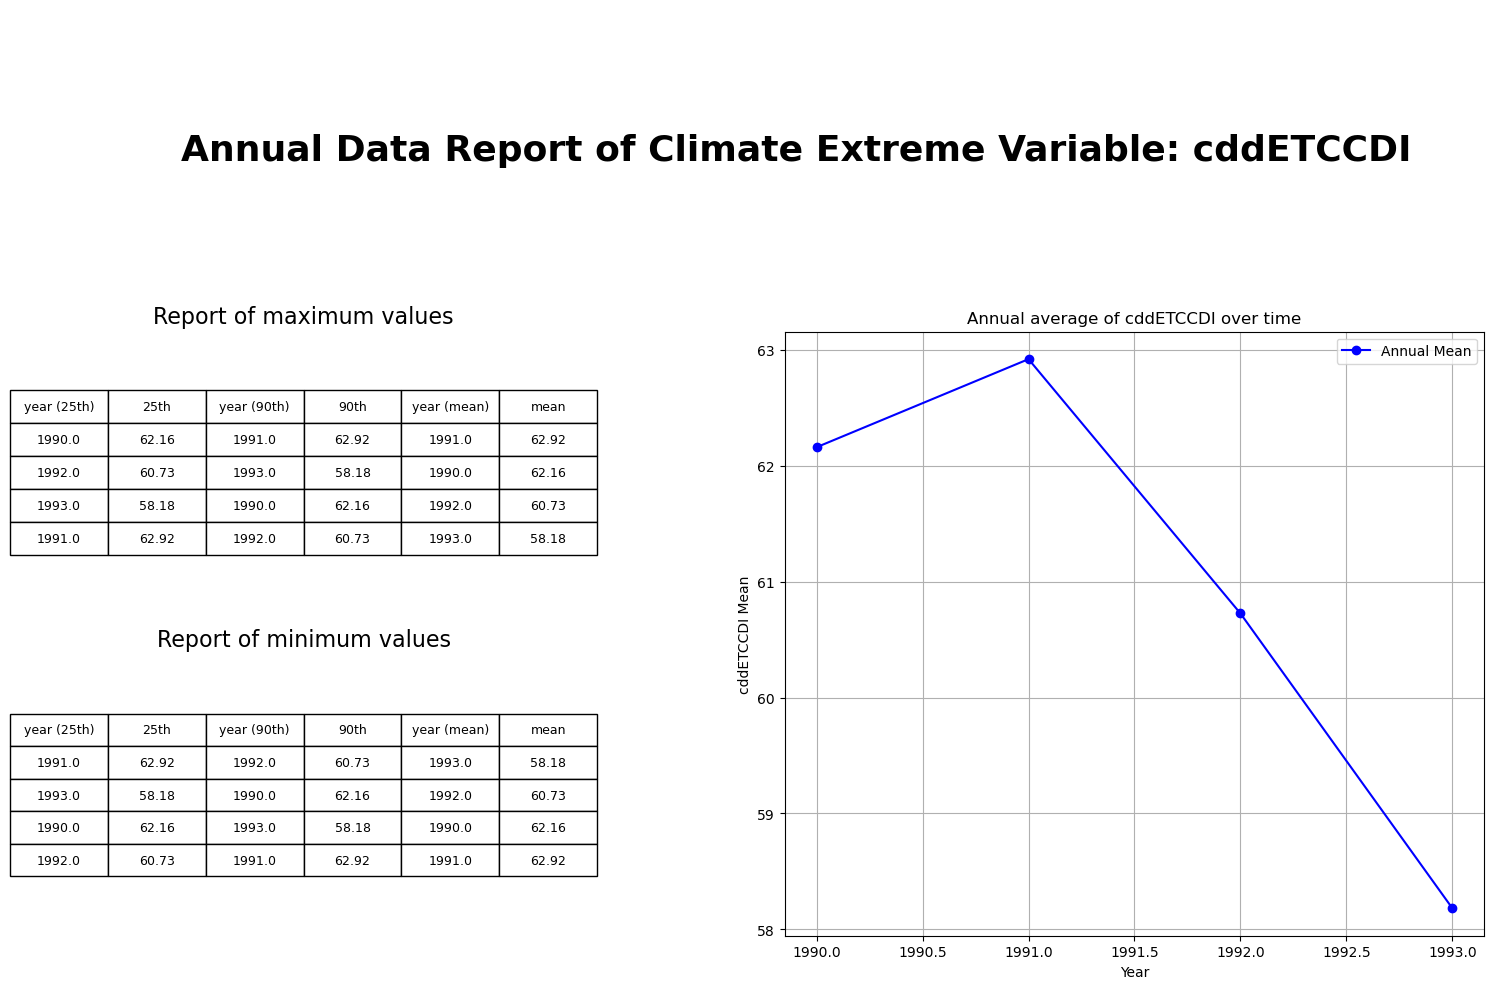

In [27]:
plot_statistics(etccdi_index, df_an, df1, df2)

In [ ]:
new_africa.pgy.full_set(self, in_africa = False, in_me = False)
